# Outlier Detection with Autoencoders

In [1]:
import os
from datetime import datetime
from typing import Dict, List, Tuple
import warnings

import numpy as np
import pandas as pd
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms

C:\Users\marti\Anaconda3\envs\bakalarka\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\marti\Anaconda3\envs\bakalarka\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\marti\Anaconda3\envs\bakalarka\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Creating and Preprocessing the Data

### Loading the data

In [2]:
cardio_dict = scipy.io.loadmat('cardio.mat')

In [3]:
cardio_dict

{'__header__': b'MATLAB 5.0 MAT-file, written by Octave 3.8.0, 2014-12-18 10:48:09 UTC',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[ 0.00491231,  0.69319077, -0.20364049, ...,  0.23149795,
         -0.28978574, -0.49329397],
        [ 0.11072935, -0.07990259, -0.20364049, ...,  0.09356344,
         -0.25638541, -0.49329397],
        [ 0.21654639, -0.27244466, -0.20364049, ...,  0.02459619,
         -0.25638541,  1.14001753],
        ...,
        [-0.41835583, -0.91998844, -0.16463485, ..., -1.49268341,
          0.24461959, -0.49329397],
        [-0.41835583, -0.91998844, -0.15093411, ..., -1.42371616,
          0.14441859, -0.49329397],
        [-0.41835583, -0.91998844, -0.20364049, ..., -1.28578165,
          3.58465295, -0.49329397]]),
 'y': array([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])}

In [4]:
X = cardio_dict['X']
y = cardio_dict['y'].flatten()

### Data splitting

Divide the dataset into inliers and outliers:
- only inliers are used for trainig the autoencoders
- outliers are then mixed with the test set

In [5]:
X_inliers = X[y==0]
y_inliers = np.zeros(len(X_inliers), dtype=int)
X_outliers = X[y==1]
y_outliers = np.ones(len(X_outliers), dtype=int)
print(f'Number of inliers: {len(y_inliers)}, Number of outliers: {len(y_outliers)}')

Number of inliers: 1655, Number of outliers: 176


Split the inliers into training, validation, and testing set:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_inliers, y_inliers, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1) # 0.25 x 0.8 = 0.2

Add outliers only to the test set

In [7]:
X_test = np.concatenate((X_test, X_outliers), axis=0)
y_test = np.concatenate((y_test, y_outliers), axis=0)

In [8]:
print(f'Training set: {len(y_train)} examples')
print(f'Validation set: {len(y_val)} examples')
print(f'Testing set: {len(y_test)} examples; inliers: {np.sum(y_test==0)}, outliers: {np.sum(y_test==1)}')

Training set: 1059 examples
Validation set: 265 examples
Testing set: 507 examples; inliers: 331, outliers: 176


In [9]:
display(X_train.shape)

(1059, 21)

### Creating Dataset and DataLoader instances

In [10]:
class CardioDataset(Dataset):
    def __init__(self, data: np.ndarray, labels: np.ndarray):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.int32]:
        return self.data[idx], self.labels[idx]

In [11]:
train_data = CardioDataset(X_train, y_train)
val_data = CardioDataset(X_val, y_val)

In [12]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)

## The Models

### 1. Undercomplete AutoEncoder

In [13]:
class UndercompleteAutoEncoder(nn.Module):
    def __init__(self):
        super(UndercompleteAutoEncoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(21, 16),
            nn.ReLU(),
            nn.Linear(16, 14),
            # nn.ReLU(),
            # nn.Linear(12, 10),
        )
        self.decode = nn.Sequential(
            # nn.Linear(10, 12),
            # nn.ReLU(),
            nn.Linear(14, 16),
            nn.ReLU(),
            nn.Linear(16, 21),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encode(x)
        x = self.decode(x)
        return x

In [14]:
undercomplete_ae = UndercompleteAutoEncoder()

learning_rate = 1e-2
optimizer = torch.optim.Adam(undercomplete_ae.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [15]:
def train_one_epoch(model: nn.Module):
    '''
    Train one epoch of the model on training dataset batched by the train_dataloader.
    
    :param nn.Module model: model on which we perform one training epoch
    :returns: an average loss on the training dataset
    '''
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, _ = data
        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs.float(), inputs.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_dataloader)

In [16]:
def train_model(model: nn.Module, model_name: str, nr_of_epochs: int = 100):
    '''
    Train the specified model, and evaluate on validation data.
        
    :param nn.Module model: model being trained
    :param str model_name: model name, e.g. denoising_autoencoder
    :param int nr_of_epochs: number of training epochs
    '''
    best_loss = 10**12
    best_model, model_path, best_epoch = None, None, None

    for epoch in range(nr_of_epochs):
        model.train()
        train_loss = train_one_epoch(model)
        model.eval()

        # performance on validation set
        valid_loss = 0.0
        for i, data in enumerate(val_dataloader):
            inputs, _ = data
            outputs = model(inputs.float())
            loss = criterion(outputs.float(), inputs.float())
            valid_loss += loss.item()
        valid_loss = valid_loss / len(val_dataloader)

        # logging at each Nth epoch
        if (epoch + 1) % 10 == 0:
            print(f'epoch {epoch + 1}; train loss: {train_loss}; valid loss: {valid_loss}')
        
        # remember model with the best validation loss
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_model = model.state_dict()
            best_epoch = epoch + 1

    # save the overall best model
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    os.makedirs('models/', exist_ok=True)
    model_path = f'models/model_{model_name}_{timestamp}_epoch{best_epoch}'
    torch.save(best_model, model_path)

In [17]:
train_model(model=undercomplete_ae, model_name='undercomplete_autoencoder', nr_of_epochs=200)

epoch 10; train loss: 0.11702963622177348; valid loss: 0.09707910194993019
epoch 20; train loss: 0.057813625782728195; valid loss: 0.04525128789246082
epoch 30; train loss: 0.040440684403566754; valid loss: 0.032058209739625455
epoch 40; train loss: 0.03180816944907693; valid loss: 0.024513636343181135
epoch 50; train loss: 0.02720780309070559; valid loss: 0.02167628053575754
epoch 60; train loss: 0.022827810169581103; valid loss: 0.017836234346032143
epoch 70; train loss: 0.020301130545489928; valid loss: 0.015880633518099783
epoch 80; train loss: 0.019658516270711142; valid loss: 0.015986318327486516
epoch 90; train loss: 0.017976164982161102; valid loss: 0.01589931473135948
epoch 100; train loss: 0.01506194576401921; valid loss: 0.014339814987033605
epoch 110; train loss: 0.014545081731151132; valid loss: 0.014738329406827688
epoch 120; train loss: 0.014310614041545811; valid loss: 0.014837839454412461
epoch 130; train loss: 0.014040038482669522; valid loss: 0.014558351319283246
epo

In [18]:
def eval_on_testset(model: nn.Module, testset: np.ndarray, test_labels: np.ndarray) -> Tuple[pd.DataFrame, np.ndarray]:
    '''
    Evaluate testing data on the model, calculate reconstruction error, print statistics on inliers and outliers
        
    :param nn.Module model: model being evaluated
    :param np.ndarray testset: testing inputs
    :param np.ndarray test_labels: ground-truth labels
    :returns: dataframe with reconstruction errors and classes, reconstrution errors
    '''
    testset_tensor = torch.tensor(testset).float()
    reconstructed_test = model(testset_tensor)
    mse_test = torch.sum((reconstructed_test.detach() - testset_tensor) ** 2, axis=1)
    error_df = pd.DataFrame({'Reconstruction Error': mse_test, 'class': y_test})
    
    display(error_df[error_df['class'] == 0].describe())
    display(error_df[error_df['class'] == 1].describe())
    return error_df, mse_test

In [19]:
test_df, test_MSEs = eval_on_testset(undercomplete_ae, X_test, y_test)

,Reconstruction Error,class
count,331.000000,331.0
mean,0.981376,0.0
std,10.945366,0.0
min,0.016502,0.0
25%,0.099972,0.0
50%,0.175698,0.0
75%,0.321621,0.0
max,198.851440,0.0


,Reconstruction Error,class
count,176.000000,176.0
mean,15.967948,1.0
std,59.908783,0.0
min,0.097872,1.0
25%,0.784876,1.0
50%,2.704035,1.0
75%,6.637720,1.0
max,448.984863,1.0


In [20]:
def classify_by_error(MSEs: np.ndarray, thres: float) -> np.ndarray:
    '''
    Classify an array of reconstruction errors w.r.t. a threshold
    
    :param np.ndarray MSEs: mean squared reconstruction errors
    :param float thres: threshold of reconstruction error between inliers and outliers
    :returns: binary array of class ids; 0 = inlier, 1 = outlier
    '''
    return np.array(MSEs > thres, dtype=int)

In [21]:
def plot_confusion_matrix(confusion_mat: np.ndarray):
    '''
    Plot a confusion matrix of true vs predicted labels.
    
    :param np.ndarray confusion_mat: confusion matrix between true and predicted labels
    '''
    class_labels = ['Inlier', 'Outlier']
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_mat, xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt="d", annot_kws={"size": 14});
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [22]:
def try_threshold_grid(MSEs: np.ndarray, true_labels: np.ndarray, model_name: str, start: float = 0.0, stop: float = 5.0, num_thresholds: int = 10) -> float:
    '''
    Plot a confusion matrix of true vs predicted labels.
    
    :param np.ndarray MSEs: mean squared reconstruction errors on testing set
    :param np.ndarray true_labels: ground-truth labels
    :param str model_name: model name, e.g. denoising_autoencoder
    :param float start: start of threshold interval
    :param float stop: end of threshold interval
    :param int num_thresholds: number of thresholds tested in the interval
    :returns: threshold with the highest anomaly f1-score
    '''
    best_threshold = None
    best_f1 = 0.0
    display(Markdown(f'## Model: {model_name}'))
    for threshold in np.linspace(start, stop, num=num_thresholds):
        predictions = classify_by_error(MSEs, threshold)
        matrix = confusion_matrix(true_labels, predictions)
        class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
        acc_df = pd.DataFrame({
            'Inliers Accuracy': [class_accuracies[0]], 
            'Outliers Accuracy': [class_accuracies[1]], 
            'Overall Accuracy': [accuracy_score(true_labels, predictions)]
        })
        
        outlier_f1 = f1_score(true_labels, predictions)
        if outlier_f1 > best_f1:
            best_f1 = outlier_f1
            best_threshold = threshold
        
        display(Markdown(f'### Threshold {threshold}'))
        display(acc_df.style.hide_index())
        display(Markdown(f'##### Classification Report'))
        print(classification_report(true_labels, predictions))
        # plot_confusion_matrix(matrix)
        display(Markdown('---'))
    
    return best_threshold

In [23]:
optimal_threshold = try_threshold_grid(test_MSEs, y_test, 'undercomplete_autoencoder', start=0.1, stop=2.0, num_thresholds=40)

## Model: undercomplete_autoencoder

### Threshold 0.1

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.250755,0.994318,0.508876


##### Classification Report

              precision    recall  f1-score   support

           0       0.99      0.25      0.40       331
           1       0.41      0.99      0.58       176

    accuracy                           0.51       507
   macro avg       0.70      0.62      0.49       507
weighted avg       0.79      0.51      0.46       507



---

### Threshold 0.14871794871794872

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.416918,0.982955,0.613412


##### Classification Report

              precision    recall  f1-score   support

           0       0.98      0.42      0.58       331
           1       0.47      0.98      0.64       176

    accuracy                           0.61       507
   macro avg       0.73      0.70      0.61       507
weighted avg       0.80      0.61      0.60       507



---

### Threshold 0.19743589743589746

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.558912,0.971591,0.702170


##### Classification Report

              precision    recall  f1-score   support

           0       0.97      0.56      0.71       331
           1       0.54      0.97      0.69       176

    accuracy                           0.70       507
   macro avg       0.76      0.77      0.70       507
weighted avg       0.82      0.70      0.70       507



---

### Threshold 0.24615384615384617

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.637462,0.943182,0.743590


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.64      0.76       331
           1       0.58      0.94      0.72       176

    accuracy                           0.74       507
   macro avg       0.77      0.79      0.74       507
weighted avg       0.82      0.74      0.75       507



---

### Threshold 0.2948717948717949

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.712991,0.931818,0.788955


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.71      0.82       331
           1       0.63      0.93      0.75       176

    accuracy                           0.79       507
   macro avg       0.79      0.82      0.78       507
weighted avg       0.84      0.79      0.79       507



---

### Threshold 0.3435897435897436

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.761329,0.920455,0.816568


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.76      0.84       331
           1       0.67      0.92      0.78       176

    accuracy                           0.82       507
   macro avg       0.81      0.84      0.81       507
weighted avg       0.85      0.82      0.82       507



---

### Threshold 0.39230769230769236

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.791541,0.903409,0.830375


##### Classification Report

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       331
           1       0.70      0.90      0.79       176

    accuracy                           0.83       507
   macro avg       0.82      0.85      0.82       507
weighted avg       0.86      0.83      0.83       507



---

### Threshold 0.441025641025641

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.809668,0.892045,0.838264


##### Classification Report

              precision    recall  f1-score   support

           0       0.93      0.81      0.87       331
           1       0.71      0.89      0.79       176

    accuracy                           0.84       507
   macro avg       0.82      0.85      0.83       507
weighted avg       0.86      0.84      0.84       507



---

### Threshold 0.4897435897435898

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.818731,0.892045,0.844181


##### Classification Report

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       331
           1       0.72      0.89      0.80       176

    accuracy                           0.84       507
   macro avg       0.83      0.86      0.84       507
weighted avg       0.86      0.84      0.85       507



---

### Threshold 0.5384615384615384

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.839879,0.863636,0.848126


##### Classification Report

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       331
           1       0.74      0.86      0.80       176

    accuracy                           0.85       507
   macro avg       0.83      0.85      0.84       507
weighted avg       0.86      0.85      0.85       507



---

### Threshold 0.5871794871794872

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.864048,0.829545,0.852071


##### Classification Report

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       331
           1       0.76      0.83      0.80       176

    accuracy                           0.85       507
   macro avg       0.83      0.85      0.84       507
weighted avg       0.86      0.85      0.85       507



---

### Threshold 0.6358974358974359

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.873112,0.806818,0.850099


##### Classification Report

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       331
           1       0.77      0.81      0.79       176

    accuracy                           0.85       507
   macro avg       0.83      0.84      0.84       507
weighted avg       0.85      0.85      0.85       507



---

### Threshold 0.6846153846153846

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.873112,0.795455,0.846154


##### Classification Report

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       331
           1       0.77      0.80      0.78       176

    accuracy                           0.85       507
   macro avg       0.83      0.83      0.83       507
weighted avg       0.85      0.85      0.85       507



---

### Threshold 0.7333333333333333

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.891239,0.772727,0.850099


##### Classification Report

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       331
           1       0.79      0.77      0.78       176

    accuracy                           0.85       507
   macro avg       0.84      0.83      0.83       507
weighted avg       0.85      0.85      0.85       507



---

### Threshold 0.782051282051282

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.900302,0.755682,0.850099


##### Classification Report

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       331
           1       0.80      0.76      0.78       176

    accuracy                           0.85       507
   macro avg       0.84      0.83      0.83       507
weighted avg       0.85      0.85      0.85       507



---

### Threshold 0.8307692307692307

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.906344,0.721591,0.842209


##### Classification Report

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       331
           1       0.80      0.72      0.76       176

    accuracy                           0.84       507
   macro avg       0.83      0.81      0.82       507
weighted avg       0.84      0.84      0.84       507



---

### Threshold 0.8794871794871795

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.912387,0.710227,0.842209


##### Classification Report

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       331
           1       0.81      0.71      0.76       176

    accuracy                           0.84       507
   macro avg       0.83      0.81      0.82       507
weighted avg       0.84      0.84      0.84       507



---

### Threshold 0.9282051282051282

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.915408,0.664773,0.828402


##### Classification Report

              precision    recall  f1-score   support

           0       0.84      0.92      0.87       331
           1       0.81      0.66      0.73       176

    accuracy                           0.83       507
   macro avg       0.82      0.79      0.80       507
weighted avg       0.83      0.83      0.82       507



---

### Threshold 0.9769230769230769

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.921450,0.659091,0.830375


##### Classification Report

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       331
           1       0.82      0.66      0.73       176

    accuracy                           0.83       507
   macro avg       0.83      0.79      0.80       507
weighted avg       0.83      0.83      0.83       507



---

### Threshold 1.0256410256410258

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.933535,0.653409,0.836292


##### Classification Report

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       331
           1       0.84      0.65      0.73       176

    accuracy                           0.84       507
   macro avg       0.84      0.79      0.81       507
weighted avg       0.84      0.84      0.83       507



---

### Threshold 1.0743589743589743

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.939577,0.647727,0.838264


##### Classification Report

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       331
           1       0.85      0.65      0.74       176

    accuracy                           0.84       507
   macro avg       0.84      0.79      0.81       507
weighted avg       0.84      0.84      0.83       507



---

### Threshold 1.123076923076923

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.945619,0.642045,0.840237


##### Classification Report

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       331
           1       0.86      0.64      0.74       176

    accuracy                           0.84       507
   macro avg       0.85      0.79      0.81       507
weighted avg       0.84      0.84      0.83       507



---

### Threshold 1.1717948717948719

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.948640,0.642045,0.842209


##### Classification Report

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       331
           1       0.87      0.64      0.74       176

    accuracy                           0.84       507
   macro avg       0.85      0.80      0.81       507
weighted avg       0.85      0.84      0.84       507



---

### Threshold 1.2205128205128206

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.951662,0.613636,0.834320


##### Classification Report

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       331
           1       0.87      0.61      0.72       176

    accuracy                           0.83       507
   macro avg       0.85      0.78      0.80       507
weighted avg       0.84      0.83      0.83       507



---

### Threshold 1.2692307692307694

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.954683,0.613636,0.836292


##### Classification Report

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       331
           1       0.88      0.61      0.72       176

    accuracy                           0.84       507
   macro avg       0.85      0.78      0.80       507
weighted avg       0.84      0.84      0.83       507



---

### Threshold 1.3179487179487182

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.957704,0.613636,0.838264


##### Classification Report

              precision    recall  f1-score   support

           0       0.82      0.96      0.89       331
           1       0.89      0.61      0.72       176

    accuracy                           0.84       507
   macro avg       0.85      0.79      0.81       507
weighted avg       0.84      0.84      0.83       507



---

### Threshold 1.3666666666666667

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.957704,0.607955,0.836292


##### Classification Report

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       331
           1       0.88      0.61      0.72       176

    accuracy                           0.84       507
   macro avg       0.85      0.78      0.80       507
weighted avg       0.84      0.84      0.83       507



---

### Threshold 1.4153846153846155

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.607955,0.838264


##### Classification Report

              precision    recall  f1-score   support

           0       0.82      0.96      0.89       331
           1       0.89      0.61      0.72       176

    accuracy                           0.84       507
   macro avg       0.86      0.78      0.80       507
weighted avg       0.85      0.84      0.83       507



---

### Threshold 1.4641025641025642

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.602273,0.836292


##### Classification Report

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       331
           1       0.89      0.60      0.72       176

    accuracy                           0.84       507
   macro avg       0.86      0.78      0.80       507
weighted avg       0.84      0.84      0.83       507



---

### Threshold 1.512820512820513

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.602273,0.836292


##### Classification Report

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       331
           1       0.89      0.60      0.72       176

    accuracy                           0.84       507
   macro avg       0.86      0.78      0.80       507
weighted avg       0.84      0.84      0.83       507



---

### Threshold 1.5615384615384615

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.596591,0.834320


##### Classification Report

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       331
           1       0.89      0.60      0.71       176

    accuracy                           0.83       507
   macro avg       0.85      0.78      0.80       507
weighted avg       0.84      0.83      0.82       507



---

### Threshold 1.6102564102564103

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.963746,0.573864,0.828402


##### Classification Report

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       331
           1       0.89      0.57      0.70       176

    accuracy                           0.83       507
   macro avg       0.85      0.77      0.79       507
weighted avg       0.84      0.83      0.82       507



---

### Threshold 1.658974358974359

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.963746,0.556818,0.822485


##### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.96      0.88       331
           1       0.89      0.56      0.69       176

    accuracy                           0.82       507
   macro avg       0.85      0.76      0.78       507
weighted avg       0.83      0.82      0.81       507



---

### Threshold 1.7076923076923078

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.966767,0.556818,0.824458


##### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       331
           1       0.90      0.56      0.69       176

    accuracy                           0.82       507
   macro avg       0.85      0.76      0.78       507
weighted avg       0.84      0.82      0.81       507



---

### Threshold 1.7564102564102566

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.966767,0.551136,0.822485


##### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       331
           1       0.90      0.55      0.68       176

    accuracy                           0.82       507
   macro avg       0.85      0.76      0.78       507
weighted avg       0.84      0.82      0.81       507



---

### Threshold 1.8051282051282052

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.969789,0.551136,0.824458


##### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       331
           1       0.91      0.55      0.69       176

    accuracy                           0.82       507
   macro avg       0.85      0.76      0.78       507
weighted avg       0.84      0.82      0.81       507



---

### Threshold 1.853846153846154

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.969789,0.551136,0.824458


##### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       331
           1       0.91      0.55      0.69       176

    accuracy                           0.82       507
   macro avg       0.85      0.76      0.78       507
weighted avg       0.84      0.82      0.81       507



---

### Threshold 1.9025641025641027

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.969789,0.551136,0.824458


##### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       331
           1       0.91      0.55      0.69       176

    accuracy                           0.82       507
   macro avg       0.85      0.76      0.78       507
weighted avg       0.84      0.82      0.81       507



---

### Threshold 1.9512820512820515

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.969789,0.551136,0.824458


##### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       331
           1       0.91      0.55      0.69       176

    accuracy                           0.82       507
   macro avg       0.85      0.76      0.78       507
weighted avg       0.84      0.82      0.81       507



---

### Threshold 2.0

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.969789,0.551136,0.824458


##### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       331
           1       0.91      0.55      0.69       176

    accuracy                           0.82       507
   macro avg       0.85      0.76      0.78       507
weighted avg       0.84      0.82      0.81       507



---

### Threshold 0.4897435897435898

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.818731,0.892045,0.844181


##### Classification Report

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       331
           1       0.72      0.89      0.80       176

    accuracy                           0.84       507
   macro avg       0.83      0.86      0.84       507
weighted avg       0.86      0.84      0.85       507



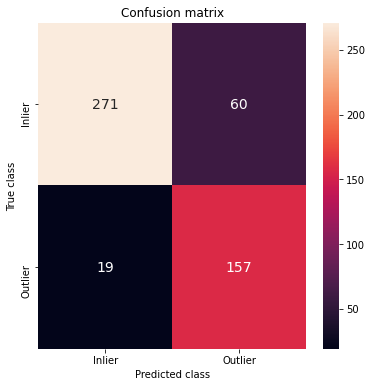

In [24]:
predictions = classify_by_error(test_MSEs, optimal_threshold)
matrix = confusion_matrix(y_test, predictions)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
acc_df = pd.DataFrame({
    'Inliers Accuracy': [class_accuracies[0]], 
    'Outliers Accuracy': [class_accuracies[1]], 
    'Overall Accuracy': [accuracy_score(y_test, predictions)]
})

display(Markdown(f'### Threshold {optimal_threshold}'))
display(acc_df.style.hide_index())
display(Markdown(f'##### Classification Report'))
print(classification_report(y_test, predictions))
plot_confusion_matrix(matrix)

---
---

### 2. Denoising AutoEncoder

In [25]:
class DenoisingAutoEncoder(nn.Module):
    def __init__(self, noise_rate):
        super(DenoisingAutoEncoder, self).__init__()
        self.noise_rate = noise_rate
        self.encode = nn.Sequential(
            nn.Linear(21, 16),
            nn.ReLU(),
            nn.Linear(16, 14),
        )
        self.decode = nn.Sequential(
            nn.Linear(14, 16),
            nn.ReLU(),
            nn.Linear(16, 21),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            # randn_like returns tensor the same shape as x with random numbers
            # from a normal distribution with mean 0 and variance 1
            x = x + torch.randn_like(x) * self.noise_rate
        x = self.encode(x)
        x = self.decode(x)
        return x

In [26]:
denoising_ae = DenoisingAutoEncoder(noise_rate=0.1)

learning_rate = 1e-2
optimizer = torch.optim.Adam(denoising_ae.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [27]:
train_model(model=denoising_ae, model_name='denoising_autoencoder', nr_of_epochs=200)

epoch 10; train loss: 0.1353264652630862; valid loss: 0.1307838410139084
epoch 20; train loss: 0.07029625357073896; valid loss: 0.05437110066413879
epoch 30; train loss: 0.05438533754033201; valid loss: 0.04268956109881401
epoch 40; train loss: 0.03967317171833094; valid loss: 0.025260810181498526
epoch 50; train loss: 0.03371260337093297; valid loss: 0.02108109127730131
epoch 60; train loss: 0.03218280173399869; valid loss: 0.022485269233584404
epoch 70; train loss: 0.03098915977513089; valid loss: 0.02141017112880945
epoch 80; train loss: 0.03024241854162777; valid loss: 0.020220891386270524
epoch 90; train loss: 0.03044742510160979; valid loss: 0.020546996593475343
epoch 100; train loss: 0.029818718595539823; valid loss: 0.020289123244583606
epoch 110; train loss: 0.029267144115532145; valid loss: 0.020047189854085445
epoch 120; train loss: 0.02943222049404593; valid loss: 0.01980901714414358
epoch 130; train loss: 0.029384995208067054; valid loss: 0.019294626824557782
epoch 140; tr

In [28]:
test_df, test_MSEs = eval_on_testset(denoising_ae, X_test, y_test)

,Reconstruction Error,class
count,331.000000,331.0
mean,0.965081,0.0
std,10.012934,0.0
min,0.044527,0.0
25%,0.145322,0.0
50%,0.242782,0.0
75%,0.423975,0.0
max,182.243759,0.0


,Reconstruction Error,class
count,176.000000,176.0
mean,13.739071,1.0
std,53.441933,0.0
min,0.092848,1.0
25%,1.126669,1.0
50%,1.748759,1.0
75%,4.193795,1.0
max,411.661224,1.0


In [29]:
optimal_threshold = try_threshold_grid(test_MSEs, y_test, 'denoising_autoencoder', start=0.1, stop=2.0, num_thresholds=40)

## Model: denoising_autoencoder

### Threshold 0.1

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.111782,0.994318,0.418146


##### Classification Report

              precision    recall  f1-score   support

           0       0.97      0.11      0.20       331
           1       0.37      0.99      0.54       176

    accuracy                           0.42       507
   macro avg       0.67      0.55      0.37       507
weighted avg       0.77      0.42      0.32       507



---

### Threshold 0.14871794871794872

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.259819,0.982955,0.510848


##### Classification Report

              precision    recall  f1-score   support

           0       0.97      0.26      0.41       331
           1       0.41      0.98      0.58       176

    accuracy                           0.51       507
   macro avg       0.69      0.62      0.50       507
weighted avg       0.77      0.51      0.47       507



---

### Threshold 0.19743589743589746

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.383686,0.971591,0.587771


##### Classification Report

              precision    recall  f1-score   support

           0       0.96      0.38      0.55       331
           1       0.46      0.97      0.62       176

    accuracy                           0.59       507
   macro avg       0.71      0.68      0.58       507
weighted avg       0.79      0.59      0.57       507



---

### Threshold 0.24615384615384617

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.513595,0.954545,0.666667


##### Classification Report

              precision    recall  f1-score   support

           0       0.96      0.51      0.67       331
           1       0.51      0.95      0.67       176

    accuracy                           0.67       507
   macro avg       0.73      0.73      0.67       507
weighted avg       0.80      0.67      0.67       507



---

### Threshold 0.2948717948717949

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.631420,0.948864,0.741617


##### Classification Report

              precision    recall  f1-score   support

           0       0.96      0.63      0.76       331
           1       0.58      0.95      0.72       176

    accuracy                           0.74       507
   macro avg       0.77      0.79      0.74       507
weighted avg       0.83      0.74      0.75       507



---

### Threshold 0.3435897435897436

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.676737,0.931818,0.765286


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.68      0.79       331
           1       0.61      0.93      0.73       176

    accuracy                           0.77       507
   macro avg       0.78      0.80      0.76       507
weighted avg       0.83      0.77      0.77       507



---

### Threshold 0.39230769230769236

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.722054,0.931818,0.794872


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.72      0.82       331
           1       0.64      0.93      0.76       176

    accuracy                           0.79       507
   macro avg       0.80      0.83      0.79       507
weighted avg       0.84      0.79      0.80       507



---

### Threshold 0.441025641025641

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.761329,0.926136,0.818540


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.76      0.85       331
           1       0.67      0.93      0.78       176

    accuracy                           0.82       507
   macro avg       0.81      0.84      0.81       507
weighted avg       0.85      0.82      0.82       507



---

### Threshold 0.4897435897435898

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.791541,0.920455,0.836292


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       331
           1       0.70      0.92      0.80       176

    accuracy                           0.84       507
   macro avg       0.83      0.86      0.83       507
weighted avg       0.86      0.84      0.84       507



---

### Threshold 0.5384615384615384

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.830816,0.909091,0.857988


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.83      0.88       331
           1       0.74      0.91      0.82       176

    accuracy                           0.86       507
   macro avg       0.84      0.87      0.85       507
weighted avg       0.87      0.86      0.86       507



---

### Threshold 0.5871794871794872

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.851964,0.909091,0.871795


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       331
           1       0.77      0.91      0.83       176

    accuracy                           0.87       507
   macro avg       0.86      0.88      0.86       507
weighted avg       0.88      0.87      0.87       507



---

### Threshold 0.6358974358974359

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.867069,0.892045,0.875740


##### Classification Report

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       331
           1       0.78      0.89      0.83       176

    accuracy                           0.88       507
   macro avg       0.86      0.88      0.87       507
weighted avg       0.88      0.88      0.88       507



---

### Threshold 0.6846153846153846

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.879154,0.863636,0.873767


##### Classification Report

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       331
           1       0.79      0.86      0.83       176

    accuracy                           0.87       507
   macro avg       0.86      0.87      0.86       507
weighted avg       0.88      0.87      0.87       507



---

### Threshold 0.7333333333333333

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.891239,0.846591,0.875740


##### Classification Report

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       331
           1       0.81      0.85      0.83       176

    accuracy                           0.88       507
   macro avg       0.86      0.87      0.86       507
weighted avg       0.88      0.88      0.88       507



---

### Threshold 0.782051282051282

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.906344,0.829545,0.879684


##### Classification Report

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       331
           1       0.82      0.83      0.83       176

    accuracy                           0.88       507
   macro avg       0.87      0.87      0.87       507
weighted avg       0.88      0.88      0.88       507



---

### Threshold 0.8307692307692307

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.912387,0.812500,0.877712


##### Classification Report

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       331
           1       0.83      0.81      0.82       176

    accuracy                           0.88       507
   macro avg       0.87      0.86      0.86       507
weighted avg       0.88      0.88      0.88       507



---

### Threshold 0.8794871794871795

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.918429,0.812500,0.881657


##### Classification Report

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       331
           1       0.84      0.81      0.83       176

    accuracy                           0.88       507
   macro avg       0.87      0.87      0.87       507
weighted avg       0.88      0.88      0.88       507



---

### Threshold 0.9282051282051282

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.918429,0.812500,0.881657


##### Classification Report

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       331
           1       0.84      0.81      0.83       176

    accuracy                           0.88       507
   macro avg       0.87      0.87      0.87       507
weighted avg       0.88      0.88      0.88       507



---

### Threshold 0.9769230769230769

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.921450,0.795455,0.877712


##### Classification Report

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       331
           1       0.84      0.80      0.82       176

    accuracy                           0.88       507
   macro avg       0.87      0.86      0.86       507
weighted avg       0.88      0.88      0.88       507



---

### Threshold 1.0256410256410258

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.921450,0.784091,0.873767


##### Classification Report

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       331
           1       0.84      0.78      0.81       176

    accuracy                           0.87       507
   macro avg       0.87      0.85      0.86       507
weighted avg       0.87      0.87      0.87       507



---

### Threshold 1.0743589743589743

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.927492,0.767045,0.871795


##### Classification Report

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       331
           1       0.85      0.77      0.81       176

    accuracy                           0.87       507
   macro avg       0.87      0.85      0.86       507
weighted avg       0.87      0.87      0.87       507



---

### Threshold 1.123076923076923

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.930514,0.755682,0.869822


##### Classification Report

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       331
           1       0.85      0.76      0.80       176

    accuracy                           0.87       507
   macro avg       0.87      0.84      0.85       507
weighted avg       0.87      0.87      0.87       507



---

### Threshold 1.1717948717948719

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.936556,0.738636,0.867850


##### Classification Report

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       331
           1       0.86      0.74      0.80       176

    accuracy                           0.87       507
   macro avg       0.87      0.84      0.85       507
weighted avg       0.87      0.87      0.87       507



---

### Threshold 1.2205128205128206

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.939577,0.727273,0.865878


##### Classification Report

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       331
           1       0.86      0.73      0.79       176

    accuracy                           0.87       507
   macro avg       0.87      0.83      0.85       507
weighted avg       0.87      0.87      0.86       507



---

### Threshold 1.2692307692307694

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.942598,0.681818,0.852071


##### Classification Report

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       331
           1       0.86      0.68      0.76       176

    accuracy                           0.85       507
   macro avg       0.86      0.81      0.83       507
weighted avg       0.85      0.85      0.85       507



---

### Threshold 1.3179487179487182

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.945619,0.664773,0.848126


##### Classification Report

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       331
           1       0.87      0.66      0.75       176

    accuracy                           0.85       507
   macro avg       0.85      0.81      0.82       507
weighted avg       0.85      0.85      0.84       507



---

### Threshold 1.3666666666666667

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.945619,0.642045,0.840237


##### Classification Report

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       331
           1       0.86      0.64      0.74       176

    accuracy                           0.84       507
   macro avg       0.85      0.79      0.81       507
weighted avg       0.84      0.84      0.83       507



---

### Threshold 1.4153846153846155

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.945619,0.625000,0.834320


##### Classification Report

              precision    recall  f1-score   support

           0       0.83      0.95      0.88       331
           1       0.86      0.62      0.72       176

    accuracy                           0.83       507
   macro avg       0.84      0.79      0.80       507
weighted avg       0.84      0.83      0.83       507



---

### Threshold 1.4641025641025642

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.951662,0.585227,0.824458


##### Classification Report

              precision    recall  f1-score   support

           0       0.81      0.95      0.88       331
           1       0.87      0.59      0.70       176

    accuracy                           0.82       507
   macro avg       0.84      0.77      0.79       507
weighted avg       0.83      0.82      0.81       507



---

### Threshold 1.512820512820513

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.954683,0.568182,0.820513


##### Classification Report

              precision    recall  f1-score   support

           0       0.81      0.95      0.87       331
           1       0.87      0.57      0.69       176

    accuracy                           0.82       507
   macro avg       0.84      0.76      0.78       507
weighted avg       0.83      0.82      0.81       507



---

### Threshold 1.5615384615384615

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.957704,0.562500,0.820513


##### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       331
           1       0.88      0.56      0.69       176

    accuracy                           0.82       507
   macro avg       0.84      0.76      0.78       507
weighted avg       0.83      0.82      0.81       507



---

### Threshold 1.6102564102564103

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.551136,0.818540


##### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       331
           1       0.88      0.55      0.68       176

    accuracy                           0.82       507
   macro avg       0.84      0.76      0.78       507
weighted avg       0.83      0.82      0.81       507



---

### Threshold 1.658974358974359

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.528409,0.810651


##### Classification Report

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       331
           1       0.88      0.53      0.66       176

    accuracy                           0.81       507
   macro avg       0.84      0.74      0.76       507
weighted avg       0.82      0.81      0.80       507



---

### Threshold 1.7076923076923078

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.517045,0.806706


##### Classification Report

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       331
           1       0.88      0.52      0.65       176

    accuracy                           0.81       507
   macro avg       0.83      0.74      0.76       507
weighted avg       0.82      0.81      0.79       507



---

### Threshold 1.7564102564102566

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.494318,0.798817


##### Classification Report

              precision    recall  f1-score   support

           0       0.78      0.96      0.86       331
           1       0.87      0.49      0.63       176

    accuracy                           0.80       507
   macro avg       0.83      0.73      0.75       507
weighted avg       0.81      0.80      0.78       507



---

### Threshold 1.8051282051282052

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.494318,0.798817


##### Classification Report

              precision    recall  f1-score   support

           0       0.78      0.96      0.86       331
           1       0.87      0.49      0.63       176

    accuracy                           0.80       507
   macro avg       0.83      0.73      0.75       507
weighted avg       0.81      0.80      0.78       507



---

### Threshold 1.853846153846154

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.471591,0.790927


##### Classification Report

              precision    recall  f1-score   support

           0       0.77      0.96      0.86       331
           1       0.86      0.47      0.61       176

    accuracy                           0.79       507
   macro avg       0.82      0.72      0.73       507
weighted avg       0.81      0.79      0.77       507



---

### Threshold 1.9025641025641027

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.966767,0.465909,0.792899


##### Classification Report

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       331
           1       0.88      0.47      0.61       176

    accuracy                           0.79       507
   macro avg       0.83      0.72      0.73       507
weighted avg       0.81      0.79      0.77       507



---

### Threshold 1.9512820512820515

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.969789,0.454545,0.790927


##### Classification Report

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       331
           1       0.89      0.45      0.60       176

    accuracy                           0.79       507
   macro avg       0.83      0.71      0.73       507
weighted avg       0.81      0.79      0.77       507



---

### Threshold 2.0

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.969789,0.448864,0.788955


##### Classification Report

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       331
           1       0.89      0.45      0.60       176

    accuracy                           0.79       507
   macro avg       0.83      0.71      0.73       507
weighted avg       0.81      0.79      0.77       507



---

### Threshold 0.6358974358974359

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.867069,0.892045,0.875740


##### Classification Report

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       331
           1       0.78      0.89      0.83       176

    accuracy                           0.88       507
   macro avg       0.86      0.88      0.87       507
weighted avg       0.88      0.88      0.88       507



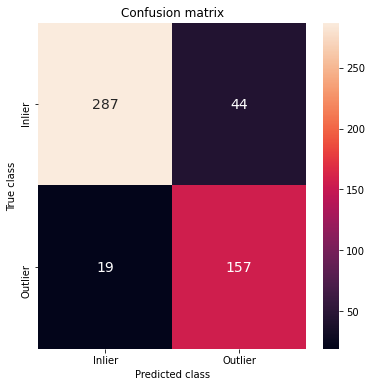

In [30]:
predictions = classify_by_error(test_MSEs, optimal_threshold)
matrix = confusion_matrix(y_test, predictions)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
acc_df = pd.DataFrame({
    'Inliers Accuracy': [class_accuracies[0]], 
    'Outliers Accuracy': [class_accuracies[1]], 
    'Overall Accuracy': [accuracy_score(y_test, predictions)]
})

display(Markdown(f'### Threshold {optimal_threshold}'))
display(acc_df.style.hide_index())
display(Markdown(f'##### Classification Report'))
print(classification_report(y_test, predictions))
plot_confusion_matrix(matrix)

---
---

### 3. Variational AutoEncoder

In [31]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        self.encLin1 = nn.Linear(21, 16)
        self.reluEnc = nn.ReLU()
        self.encLin21 = nn.Linear(16, 14)
        self.encLin22 = nn.Linear(16, 14)
        self.normal = torch.distributions.Normal(0, 1)
        self.kl = 0
        
        self.decLin1 = nn.Linear(14, 16)
        self.reluDec = nn.ReLU()
        self.decLin2 = nn.Linear(16, 21)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.reluEnc(self.encLin1(x))
        mu = self.encLin21(x)
        sigma = torch.exp(self.encLin22(x))
        z = mu + sigma * self.normal.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).mean()

        x = self.reluDec(self.decLin1(z))
        x = self.decLin2(x)
        return x

In [32]:
variational_ae = VariationalAutoEncoder()

learning_rate = 1e-2
optimizer = torch.optim.Adam(variational_ae.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [33]:
def train_one_epoch_VAE(model: nn.Module):
    '''
    Train one epoch of the model on training dataset batched by the train_dataloader.
    
    :param nn.Module model: model on which we perform one training epoch
    :returns: an average loss on the training dataset
    '''
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, _ = data
        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = ((outputs.float() - inputs.float()) ** 2).mean() + model.kl
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_dataloader)

In [34]:
def train_model_VAE(model: nn.Module, model_name: str, nr_of_epochs: int = 100):
    '''
    Train the specified model, and evaluate on validation data.
        
    :param nn.Module model: model being trained
    :param str model_name: model name, e.g. denoising_autoencoder
    :param int nr_of_epochs: number of training epochs
    '''
    best_loss = 10**12
    best_model, model_path, best_epoch = None, None, None

    for epoch in range(nr_of_epochs):
        model.train()
        train_loss = train_one_epoch_VAE(model)
        model.eval()

        # performance on validation set
        with torch.no_grad():
            valid_loss = 0.0
            for i, data in enumerate(val_dataloader):
                inputs, _ = data
                outputs = model(inputs.float())
                loss = ((outputs.float() - inputs.float()) ** 2).mean() + model.kl
                valid_loss += loss.item()
            valid_loss = valid_loss / len(val_dataloader)

            # logging at each Nth epoch
            if (epoch + 1) % 10 == 0:
                print(f'epoch {epoch + 1}; train loss: {train_loss}; valid loss: {valid_loss}')

            # remember model with the best validation loss
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_model = model.state_dict()
                best_epoch = epoch + 1

    # save the overall best model
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    os.makedirs('models/', exist_ok=True)
    model_path = f'models/model_{model_name}_{timestamp}_epoch{best_epoch}'
    torch.save(best_model, model_path)

In [35]:
train_model_VAE(model=variational_ae, model_name='variational_autoencoder', nr_of_epochs=200)

epoch 10; train loss: 0.950592931579141; valid loss: 0.9253044962882996
epoch 20; train loss: 0.9488668511895573; valid loss: 0.9190170764923096
epoch 30; train loss: 0.9372600527370677; valid loss: 0.9205188274383544
epoch 40; train loss: 0.9393444026217741; valid loss: 0.9331878185272217
epoch 50; train loss: 0.932211325449102; valid loss: 0.9256301760673523
epoch 60; train loss: 0.9286627979839549; valid loss: 0.926736032962799
epoch 70; train loss: 0.9259502817602718; valid loss: 0.9300982832908631
epoch 80; train loss: 0.9221653166939231; valid loss: 0.9174100637435914
epoch 90; train loss: 0.9206429404370925; valid loss: 0.926757299900055
epoch 100; train loss: 0.9171543717384338; valid loss: 0.9091792464256286
epoch 110; train loss: 0.9111351511057686; valid loss: 0.9153097152709961
epoch 120; train loss: 0.9109470248222351; valid loss: 0.9053551197052002
epoch 130; train loss: 0.9035387600169462; valid loss: 0.9148525357246399
epoch 140; train loss: 0.8971100519685185; valid lo

In [36]:
def eval_on_testset_VAE(model: nn.Module, testset: np.ndarray, test_labels: np.ndarray) -> Tuple[pd.DataFrame, np.ndarray]:
    '''
    Evaluate testing data on the model, calculate reconstruction error, print statistics on inliers and outliers
        
    :param nn.Module model: model being evaluated
    :param np.ndarray testset: testing inputs
    :param np.ndarray test_labels: ground-truth labels
    :returns: dataframe with reconstruction errors and classes, reconstrution errors
    '''
    testset_tensor = torch.tensor(testset).float()
    reconstructed_test = model(testset_tensor)
    mse_test = torch.mean((reconstructed_test.detach() - testset_tensor) ** 2, axis=1) + model.kl
    error_df = pd.DataFrame({'Reconstruction Error': mse_test, 'class': y_test})
    
    display(error_df[error_df['class'] == 0].describe())
    display(error_df[error_df['class'] == 1].describe())
    return error_df, mse_test

In [37]:
test_df, test_MSEs = eval_on_testset(denoising_ae, X_test, y_test)

,Reconstruction Error,class
count,331.000000,331.0
mean,0.965081,0.0
std,10.012934,0.0
min,0.044527,0.0
25%,0.145322,0.0
50%,0.242782,0.0
75%,0.423975,0.0
max,182.243759,0.0


,Reconstruction Error,class
count,176.000000,176.0
mean,13.739071,1.0
std,53.441933,0.0
min,0.092848,1.0
25%,1.126669,1.0
50%,1.748759,1.0
75%,4.193795,1.0
max,411.661224,1.0


In [38]:
optimal_threshold = try_threshold_grid(test_MSEs, y_test, 'variational_autoencoder', start=0.1, stop=2.0, num_thresholds=40)

## Model: variational_autoencoder

### Threshold 0.1

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.111782,0.994318,0.418146


##### Classification Report

              precision    recall  f1-score   support

           0       0.97      0.11      0.20       331
           1       0.37      0.99      0.54       176

    accuracy                           0.42       507
   macro avg       0.67      0.55      0.37       507
weighted avg       0.77      0.42      0.32       507



---

### Threshold 0.14871794871794872

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.259819,0.982955,0.510848


##### Classification Report

              precision    recall  f1-score   support

           0       0.97      0.26      0.41       331
           1       0.41      0.98      0.58       176

    accuracy                           0.51       507
   macro avg       0.69      0.62      0.50       507
weighted avg       0.77      0.51      0.47       507



---

### Threshold 0.19743589743589746

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.383686,0.971591,0.587771


##### Classification Report

              precision    recall  f1-score   support

           0       0.96      0.38      0.55       331
           1       0.46      0.97      0.62       176

    accuracy                           0.59       507
   macro avg       0.71      0.68      0.58       507
weighted avg       0.79      0.59      0.57       507



---

### Threshold 0.24615384615384617

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.513595,0.954545,0.666667


##### Classification Report

              precision    recall  f1-score   support

           0       0.96      0.51      0.67       331
           1       0.51      0.95      0.67       176

    accuracy                           0.67       507
   macro avg       0.73      0.73      0.67       507
weighted avg       0.80      0.67      0.67       507



---

### Threshold 0.2948717948717949

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.631420,0.948864,0.741617


##### Classification Report

              precision    recall  f1-score   support

           0       0.96      0.63      0.76       331
           1       0.58      0.95      0.72       176

    accuracy                           0.74       507
   macro avg       0.77      0.79      0.74       507
weighted avg       0.83      0.74      0.75       507



---

### Threshold 0.3435897435897436

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.676737,0.931818,0.765286


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.68      0.79       331
           1       0.61      0.93      0.73       176

    accuracy                           0.77       507
   macro avg       0.78      0.80      0.76       507
weighted avg       0.83      0.77      0.77       507



---

### Threshold 0.39230769230769236

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.722054,0.931818,0.794872


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.72      0.82       331
           1       0.64      0.93      0.76       176

    accuracy                           0.79       507
   macro avg       0.80      0.83      0.79       507
weighted avg       0.84      0.79      0.80       507



---

### Threshold 0.441025641025641

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.761329,0.926136,0.818540


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.76      0.85       331
           1       0.67      0.93      0.78       176

    accuracy                           0.82       507
   macro avg       0.81      0.84      0.81       507
weighted avg       0.85      0.82      0.82       507



---

### Threshold 0.4897435897435898

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.791541,0.920455,0.836292


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       331
           1       0.70      0.92      0.80       176

    accuracy                           0.84       507
   macro avg       0.83      0.86      0.83       507
weighted avg       0.86      0.84      0.84       507



---

### Threshold 0.5384615384615384

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.830816,0.909091,0.857988


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.83      0.88       331
           1       0.74      0.91      0.82       176

    accuracy                           0.86       507
   macro avg       0.84      0.87      0.85       507
weighted avg       0.87      0.86      0.86       507



---

### Threshold 0.5871794871794872

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.851964,0.909091,0.871795


##### Classification Report

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       331
           1       0.77      0.91      0.83       176

    accuracy                           0.87       507
   macro avg       0.86      0.88      0.86       507
weighted avg       0.88      0.87      0.87       507



---

### Threshold 0.6358974358974359

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.867069,0.892045,0.875740


##### Classification Report

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       331
           1       0.78      0.89      0.83       176

    accuracy                           0.88       507
   macro avg       0.86      0.88      0.87       507
weighted avg       0.88      0.88      0.88       507



---

### Threshold 0.6846153846153846

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.879154,0.863636,0.873767


##### Classification Report

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       331
           1       0.79      0.86      0.83       176

    accuracy                           0.87       507
   macro avg       0.86      0.87      0.86       507
weighted avg       0.88      0.87      0.87       507



---

### Threshold 0.7333333333333333

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.891239,0.846591,0.875740


##### Classification Report

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       331
           1       0.81      0.85      0.83       176

    accuracy                           0.88       507
   macro avg       0.86      0.87      0.86       507
weighted avg       0.88      0.88      0.88       507



---

### Threshold 0.782051282051282

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.906344,0.829545,0.879684


##### Classification Report

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       331
           1       0.82      0.83      0.83       176

    accuracy                           0.88       507
   macro avg       0.87      0.87      0.87       507
weighted avg       0.88      0.88      0.88       507



---

### Threshold 0.8307692307692307

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.912387,0.812500,0.877712


##### Classification Report

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       331
           1       0.83      0.81      0.82       176

    accuracy                           0.88       507
   macro avg       0.87      0.86      0.86       507
weighted avg       0.88      0.88      0.88       507



---

### Threshold 0.8794871794871795

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.918429,0.812500,0.881657


##### Classification Report

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       331
           1       0.84      0.81      0.83       176

    accuracy                           0.88       507
   macro avg       0.87      0.87      0.87       507
weighted avg       0.88      0.88      0.88       507



---

### Threshold 0.9282051282051282

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.918429,0.812500,0.881657


##### Classification Report

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       331
           1       0.84      0.81      0.83       176

    accuracy                           0.88       507
   macro avg       0.87      0.87      0.87       507
weighted avg       0.88      0.88      0.88       507



---

### Threshold 0.9769230769230769

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.921450,0.795455,0.877712


##### Classification Report

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       331
           1       0.84      0.80      0.82       176

    accuracy                           0.88       507
   macro avg       0.87      0.86      0.86       507
weighted avg       0.88      0.88      0.88       507



---

### Threshold 1.0256410256410258

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.921450,0.784091,0.873767


##### Classification Report

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       331
           1       0.84      0.78      0.81       176

    accuracy                           0.87       507
   macro avg       0.87      0.85      0.86       507
weighted avg       0.87      0.87      0.87       507



---

### Threshold 1.0743589743589743

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.927492,0.767045,0.871795


##### Classification Report

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       331
           1       0.85      0.77      0.81       176

    accuracy                           0.87       507
   macro avg       0.87      0.85      0.86       507
weighted avg       0.87      0.87      0.87       507



---

### Threshold 1.123076923076923

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.930514,0.755682,0.869822


##### Classification Report

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       331
           1       0.85      0.76      0.80       176

    accuracy                           0.87       507
   macro avg       0.87      0.84      0.85       507
weighted avg       0.87      0.87      0.87       507



---

### Threshold 1.1717948717948719

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.936556,0.738636,0.867850


##### Classification Report

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       331
           1       0.86      0.74      0.80       176

    accuracy                           0.87       507
   macro avg       0.87      0.84      0.85       507
weighted avg       0.87      0.87      0.87       507



---

### Threshold 1.2205128205128206

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.939577,0.727273,0.865878


##### Classification Report

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       331
           1       0.86      0.73      0.79       176

    accuracy                           0.87       507
   macro avg       0.87      0.83      0.85       507
weighted avg       0.87      0.87      0.86       507



---

### Threshold 1.2692307692307694

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.942598,0.681818,0.852071


##### Classification Report

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       331
           1       0.86      0.68      0.76       176

    accuracy                           0.85       507
   macro avg       0.86      0.81      0.83       507
weighted avg       0.85      0.85      0.85       507



---

### Threshold 1.3179487179487182

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.945619,0.664773,0.848126


##### Classification Report

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       331
           1       0.87      0.66      0.75       176

    accuracy                           0.85       507
   macro avg       0.85      0.81      0.82       507
weighted avg       0.85      0.85      0.84       507



---

### Threshold 1.3666666666666667

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.945619,0.642045,0.840237


##### Classification Report

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       331
           1       0.86      0.64      0.74       176

    accuracy                           0.84       507
   macro avg       0.85      0.79      0.81       507
weighted avg       0.84      0.84      0.83       507



---

### Threshold 1.4153846153846155

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.945619,0.625000,0.834320


##### Classification Report

              precision    recall  f1-score   support

           0       0.83      0.95      0.88       331
           1       0.86      0.62      0.72       176

    accuracy                           0.83       507
   macro avg       0.84      0.79      0.80       507
weighted avg       0.84      0.83      0.83       507



---

### Threshold 1.4641025641025642

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.951662,0.585227,0.824458


##### Classification Report

              precision    recall  f1-score   support

           0       0.81      0.95      0.88       331
           1       0.87      0.59      0.70       176

    accuracy                           0.82       507
   macro avg       0.84      0.77      0.79       507
weighted avg       0.83      0.82      0.81       507



---

### Threshold 1.512820512820513

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.954683,0.568182,0.820513


##### Classification Report

              precision    recall  f1-score   support

           0       0.81      0.95      0.87       331
           1       0.87      0.57      0.69       176

    accuracy                           0.82       507
   macro avg       0.84      0.76      0.78       507
weighted avg       0.83      0.82      0.81       507



---

### Threshold 1.5615384615384615

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.957704,0.562500,0.820513


##### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       331
           1       0.88      0.56      0.69       176

    accuracy                           0.82       507
   macro avg       0.84      0.76      0.78       507
weighted avg       0.83      0.82      0.81       507



---

### Threshold 1.6102564102564103

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.551136,0.818540


##### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       331
           1       0.88      0.55      0.68       176

    accuracy                           0.82       507
   macro avg       0.84      0.76      0.78       507
weighted avg       0.83      0.82      0.81       507



---

### Threshold 1.658974358974359

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.528409,0.810651


##### Classification Report

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       331
           1       0.88      0.53      0.66       176

    accuracy                           0.81       507
   macro avg       0.84      0.74      0.76       507
weighted avg       0.82      0.81      0.80       507



---

### Threshold 1.7076923076923078

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.517045,0.806706


##### Classification Report

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       331
           1       0.88      0.52      0.65       176

    accuracy                           0.81       507
   macro avg       0.83      0.74      0.76       507
weighted avg       0.82      0.81      0.79       507



---

### Threshold 1.7564102564102566

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.494318,0.798817


##### Classification Report

              precision    recall  f1-score   support

           0       0.78      0.96      0.86       331
           1       0.87      0.49      0.63       176

    accuracy                           0.80       507
   macro avg       0.83      0.73      0.75       507
weighted avg       0.81      0.80      0.78       507



---

### Threshold 1.8051282051282052

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.494318,0.798817


##### Classification Report

              precision    recall  f1-score   support

           0       0.78      0.96      0.86       331
           1       0.87      0.49      0.63       176

    accuracy                           0.80       507
   macro avg       0.83      0.73      0.75       507
weighted avg       0.81      0.80      0.78       507



---

### Threshold 1.853846153846154

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.960725,0.471591,0.790927


##### Classification Report

              precision    recall  f1-score   support

           0       0.77      0.96      0.86       331
           1       0.86      0.47      0.61       176

    accuracy                           0.79       507
   macro avg       0.82      0.72      0.73       507
weighted avg       0.81      0.79      0.77       507



---

### Threshold 1.9025641025641027

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.966767,0.465909,0.792899


##### Classification Report

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       331
           1       0.88      0.47      0.61       176

    accuracy                           0.79       507
   macro avg       0.83      0.72      0.73       507
weighted avg       0.81      0.79      0.77       507



---

### Threshold 1.9512820512820515

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.969789,0.454545,0.790927


##### Classification Report

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       331
           1       0.89      0.45      0.60       176

    accuracy                           0.79       507
   macro avg       0.83      0.71      0.73       507
weighted avg       0.81      0.79      0.77       507



---

### Threshold 2.0

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.969789,0.448864,0.788955


##### Classification Report

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       331
           1       0.89      0.45      0.60       176

    accuracy                           0.79       507
   macro avg       0.83      0.71      0.73       507
weighted avg       0.81      0.79      0.77       507



---

### Threshold 0.6358974358974359

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.867069,0.892045,0.875740


##### Classification Report

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       331
           1       0.78      0.89      0.83       176

    accuracy                           0.88       507
   macro avg       0.86      0.88      0.87       507
weighted avg       0.88      0.88      0.88       507



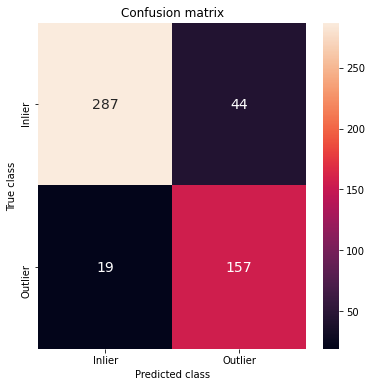

In [39]:
predictions = classify_by_error(test_MSEs, optimal_threshold)
matrix = confusion_matrix(y_test, predictions)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
acc_df = pd.DataFrame({
    'Inliers Accuracy': [class_accuracies[0]], 
    'Outliers Accuracy': [class_accuracies[1]], 
    'Overall Accuracy': [accuracy_score(y_test, predictions)]
})

display(Markdown(f'### Threshold {optimal_threshold}'))
display(acc_df.style.hide_index())
display(Markdown(f'##### Classification Report'))
print(classification_report(y_test, predictions))
plot_confusion_matrix(matrix)

---
---

## Final Remarks

I have compared three different autoencoder architectures for outlier detection:
1. undercomplete autoencoder
2. denoising autoencoder
3. variational autoencoder

For each of them, I tuned the following hyperparameters:
- learning rate
- batch size
- number of layers and their width (most importantly the size of the latent space)
- threshold for reconstruction error

I have chosen the best classifier based on the F1-score, where negative class is composed of inliers and positive class is composed of outliers.

Below, you can find the best hyper-parameters of the architectures. As for the layers, only encoder architecture is shown, since decoder contains the same layers reversed.

In [40]:
result_df = pd.DataFrame({'Architecture': ['Undercomplete Autoencoder', 'Denoising Autoencoder', 'Variational Autoencoder'],
                          'Learning Rate': [1e-2, 1e-2, 1e-2],
                          'Batch Size': [64, 64, 64], 
                          'Architecture Encoder': [
                              'Linear(21, 16) → ReLU → Linear(16, 14)', 'Linear(21, 16) → ReLU → Linear(16, 14)', 'Linear(21, 16) → ReLU → Linear(16, 14)'
                          ],
                          'Latent Space Size': [14, 14, 14],
                          'Reconstruction MSE Threshold': [0.489744, 0.635897, 0.635897],
                         })
result_df = result_df.set_index('Architecture')
display(result_df)

,Learning Rate,Batch Size,Architecture Encoder,Latent Space Size,Reconstruction MSE Threshold
Architecture,,,,,
Undercomplete Autoencoder,0.01,64,"Linear(21, 16) → ReLU → Linear(16, 14)",14,0.489744
Denoising Autoencoder,0.01,64,"Linear(21, 16) → ReLU → Linear(16, 14)",14,0.635897
Variational Autoencoder,0.01,64,"Linear(21, 16) → ReLU → Linear(16, 14)",14,0.635897
